_Version log: Branch of V19. Optimisation using MCMC Metropolis._

In [77]:
import sys, time
import numpy as np
import CS_functions as cs
from matplotlib import pyplot as plt
from scipy import fft as spfft
from tqdm import tqdm

plt.rcParams.update({'font.size':16})
np.set_printoptions(threshold=sys.maxsize)

In [78]:
file_number = 33
file_name = "1dmockanderrors{:d}".format(file_number)
file_type = ".csv"

target, target_err = cs.open_dataset(file_name, ".csv")
optlocs_file = "data\\" + file_name +"_optlocs.csv"

In [79]:
iterations = 25000
reduced_points = 8
regularization_coeffient = 1e-2 # DECREASE FOR COMPLEX IMAGES (up to 1e-7 (floating point error?)) INCREASE FOR SIMPLE IMAGES (up to 1e-2)
stepsize = 5
min_seperation = 1
subsampling_method= "centered"

In [80]:
#########INITAILISATION##########

start_time = time.time()

total_points = len(target)

detectors = cs.subsample_1d(total_points, reduced_points, subsampling_method)
detector_configerations = np.array(detectors)

score = cs.evaluate_score(detectors, target, target_err, regularization_coeffient)
scores = np.array([score])

#######START MCMC Metropolis###########
for n in tqdm(range(iterations)):
    steps = stepsize #reset steps
    new_detectors = detectors #reset detectors
    new_score = score #reset score

    while steps > 0:
        random_detector = np.random.randint(0, reduced_points) #random number between 0 and reduced_points. Includes 0. Excludes reduced_points

        current = new_detectors[random_detector]
        previous = -1 if random_detector == 0 else new_detectors[random_detector -1]
        next = total_points if random_detector == reduced_points -1 else new_detectors[random_detector +1]

        if previous +min_seperation < current and current < next -min_seperation:
            #detector has space to move forward or back.
            new_detectors[random_detector] += np.random.choice([-1,1])
            steps -= 1
        elif previous +min_seperation < current:
            #detector has space to move back.
            new_detectors[random_detector] -= 1
            steps -= 1
        elif current < next -min_seperation:
            #detector has space to move forward.
            new_detectors[random_detector] += 1
            steps -= 1
        else:
            #detector can't move.
            pass

    new_score = cs.evaluate_score(new_detectors, target, target_err, regularization_coeffient)
    acceptance = np.exp(score -new_score) # Normally MCMC uses `new_score /score` but I am looking for a minimum point so this scheme is better.

    detector_configerations = np.vstack((detector_configerations, new_detectors))

    if acceptance > np.random.rand():
        detectors = new_detectors
        score = new_score

    scores = np.append(scores, score)


###FINALISATION AFTER LOOP

best_iteration = np.argmin(scores)
detectors = detector_configerations[best_iteration]
score = scores[best_iteration]

runtime = time.time() -start_time
print(f"MCMC searched for {runtime} seconds and found a solution after {runtime *best_iteration/iterations} seconds")

100%|██████████| 25000/25000 [00:22<00:00, 1134.72it/s]

MCMC searched for 22.03485369682312 seconds and found a solution after 0.1348533046245575 seconds


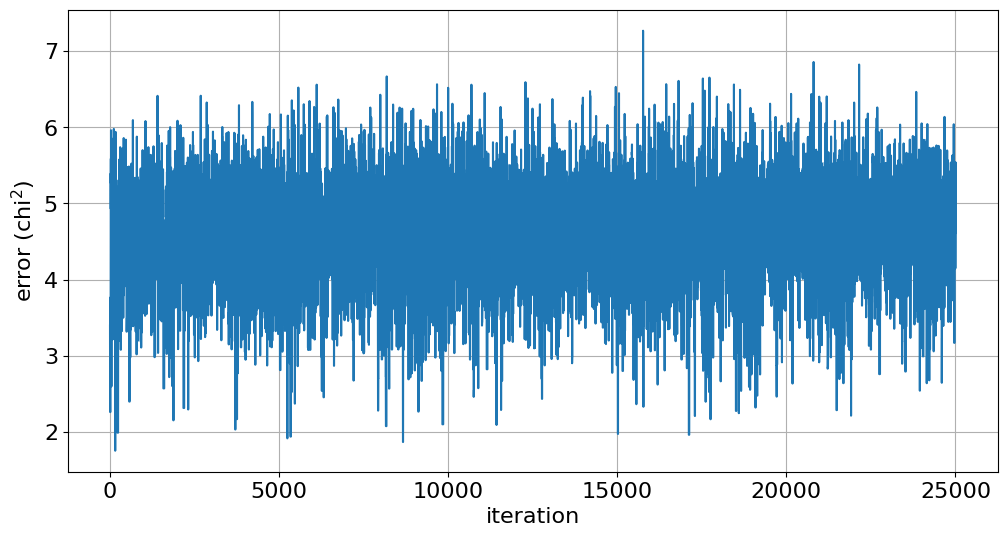

In [81]:
fig, axs = plt.subplots(figsize= (12,6))

axs.plot(scores)
axs.grid(True)
axs.set(ylabel= "error (chi$^2$)", xlabel= "iteration")

plt.show()

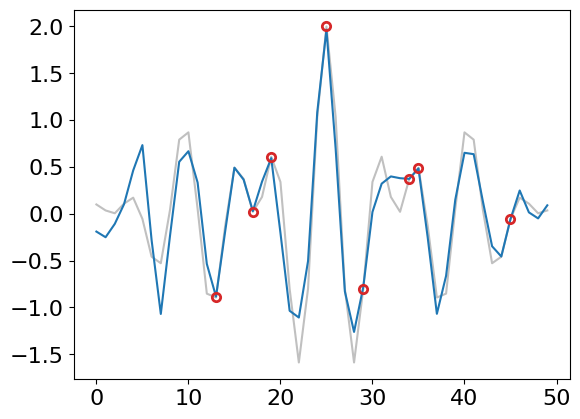

In [82]:
samples = np.full_like(target, np.nan)
samples[detectors] = target[detectors]
result = cs.compressed_sensing(samples, regularization_coeffient)

plt.plot(target, color= "silver")
plt.plot(result)
plt.plot(samples, marker= "o", linestyle= "none", markeredgecolor= "tab:red", markerfacecolor= "none", markeredgewidth= 2)
#plt.vlines(detector_configerations[0], ymin= 0, ymax= 1, linestyle= ":", color= "k", transform= plt.gca().get_xaxis_transform())
plt.show()

In [83]:
cs.evaluate_score(detectors, target, target_err, regularization_coeffient)

np.float64(1.7528216289218823)

In [84]:
cs.append_array_to_csv(detectors, optlocs_file)

print(*detectors, sep= ",")

13,17,19,25,29,34,35,45
